## Model Result Analysis

In [45]:
# change cwd above src
import os
if str(os.getcwd())[-3:] == 'src': 
    os.chdir(str(os.getcwd())+'/..')
    print(os.getcwd())

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import datetime
import yaml
from abc import ABCMeta, abstractmethod
from sklearn.model_selection import TimeSeriesSplit
from visualization.visualize import plot_model_evaluation

In [50]:
# get list of experiments run
experiment_files = [experiment.split('/')[-1] for experiment in glob("results/experiments/*", recursive = True)]
experiments = [experiment.replace('_', ' ') for experiment in experiment_files]
print('DIFFERENT EXPERIMENTS RUN...\n')
for i, experiment in enumerate(experiments):
    print(f"    {i+1}. {experiment}")

DIFFERENT EXPERIMENTS RUN...

    1. ANN DWT WINDOWED
    2. SARIMA BASIC 24
    3. SARIMA BASIC 168
    4. TEST
    5. ANN SARIMA RESIDUAL FRAGMENT
    6. ANN CEEMDAN FRAGMENTS
    7. ANN BASIC
    8. ANN BASIC V2
    9. ANN DIURNAL FRAGMENT
    10. ANN BASIC FRAGMENT
    11. ANN BASIC VIRTUAL
    12. SARIMAX CEEMDAN
    13. ANN CEEMDAN WINDOWED
    14. SARIMAX DIURNAL
    15. ANN DWT FRAGMENTS


In [72]:
# Print multi validation metric for each experiment
report_metrics = ['MSE', 'MAPE', 'RMSE', 'MAE', 'error_std']
comparison_df = pd.DataFrame(index=report_metrics)
forecast_datasets = {}

# iterate over experiments
for n, test in enumerate(experiment_files): 
    print(f"\n{n+1}. {experiments[n]}")

    # pre-allocate forecast dict
    forecast_datasets[experiments[n]] = {}

    # get path to experiment result file
    path = "results/experiments/"+test+"/*"
    tests = [test[:-4] for test in glob(path, recursive = True)]
    forecasts = [forecast for forecast in tests if forecast.split('_')[-1] == 'forecast']
    metrics  = [metric for metric in tests if metric.split('_')[-1] == 'metrics']
    
    # separate forecast results and join decompositions
    for forecast in forecasts:
        df_forecast = pd.read_csv(forecast+'.csv')
        if ('CEEMDAN' in forecast.split('/')[-1].split('_')) or ('DWT' in forecast.split('/')[-1].split('_')): 
            label = ' '.join(forecast.split('/')[-1].split('_')[1].upper())
            # sum decomposition elements
            if label not in forecast_datasets[experiments[n]].keys():
                forecast_datasets[experiments[n]][label] = df_forecast
            else: 
                forecast_datasets[experiments[n]][label] += df_forecast
        else: 
            label = ' '.join(forecast.split('/')[-1].split('_')[1].upper())
            forecast_datasets[experiments[n]][label] = df_forecast

    # separate metric results
    for metric in metrics:
        # assign label
        if ('CEEMDAN' not in metric.split('/')[-1].split('_')) or ('DWT' not in metric.split('/')[-1].split('_')): 
            label = ' '.join([experiments[n]] + [metric.split('/')[-1].split('_')[1].upper()])
            #print(f"\n{label}") 
            # get table of metrics
            df_metric = pd.read_csv(metric+'.csv').set_index('Fold')
            df_metric = df_metric.rename(columns={col: '_'.join(col.split('_')[:-1]) for col in df_metric.columns if col.split('_')[-1] == 'mean'})
            mean_vals = df_metric.loc['mean', report_metrics].T
            comparison_df[str(label)] = mean_vals

# get metric for DWT and CEEMDAN
# Combine decomposed forecasts
report_metrics = ['MSE', 'MSE_std', 'MAPE', 'MAPE_std', 'MAE', 'RMSE']
tests = [test for test in forecast_datasets.keys() if ('DWT' in test.split()) or ('CEEMDAN' in test.split())]
for experiment in tests: 
    # key metrics
    for dma in forecast_datasets[experiment].keys(): 
        no_folds = max([int(col[-3]) for col in forecast_datasets[experiment][dma].columns])+1
        no_test = max([int(col[-1]) for col in forecast_datasets[experiment][dma].columns])+1
        pointer = 0
        width_df = int(forecast_datasets[experiment][dma].shape[1] / (no_folds * no_test))
        metrics = pd.DataFrame()

        for test in range(no_test):
            for fold in range(no_folds): 
                forecast_df = forecast_datasets[experiment][dma]
                forecast_df = forecast_df.iloc[:, pointer: pointer+width_df].rename(columns={col: col[:-9] for col in forecast_df.columns})

                if (test == 0) and (fold == 0): 
                    metrics = decomposition_metrics(forecast_df)
                else: 
                    metrics = pd.concat([metrics, decomposition_metrics(forecast_df)])
                
                # move to next fold
                pointer += width_df
        
        # get avg run
        forecast_avg = forecast_datasets[experiment][dma].copy()
        forecast_avg = forecast_avg.rename(columns={col: col[:-9] for col in forecast_avg.columns})
        for col in forecast_avg.columns.unique(): 
            forecast_datasets[experiment][dma]['mean_'+col+'_fold_0_0'] = forecast_avg[col].mean(axis=1)

        metrics.loc['mean', :] = metrics.mean()
        metrics.loc['std', :] = metrics.std()

        metrics = metrics.loc['mean', report_metrics]
        comparison_df[experiment+' '+dma] = metrics
    
    


1. ANN DWT WINDOWED

2. SARIMA BASIC 24

3. SARIMA BASIC 168

4. TEST

5. ANN SARIMA RESIDUAL FRAGMENT

6. ANN CEEMDAN FRAGMENTS

7. ANN BASIC

8. ANN BASIC V2

9. ANN DIURNAL FRAGMENT

10. ANN BASIC FRAGMENT

11. ANN BASIC VIRTUAL

12. SARIMAX CEEMDAN

13. ANN CEEMDAN WINDOWED

14. SARIMAX DIURNAL

15. ANN DWT FRAGMENTS


In [82]:
comparison_df.sort_index(axis=1)

MSE          2.464678
MAPE         0.052390
RMSE         1.507302
MAE          1.163230
error_std         NaN
Name: ANN DWT FRAGMENTS I, dtype: float64

In [13]:
forecast_df.loc[-10:, 'a'] = 55
forecast_df

,gt,model,residuals,conf_int_low,conf_int_up,forecast,error,pred_int_low,pred_int_up,test_pred,error_pct,a
0,37.98,36.722057,1.257943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0
1,32.10,32.567748,-0.467750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0
2,29.10,29.306721,-0.206721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0
3,27.93,28.101506,-0.171506,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0
4,29.72,29.636130,0.083870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...
659,34.02,NaN,NaN,30.921385,34.858930,32.890158,1.129842,29.014049,36.766266,34.463947,0.033211,55.0
660,34.90,NaN,NaN,31.630952,35.568498,33.599725,1.300275,29.723617,37.475833,35.877052,0.037257,55.0
661,32.34,NaN,NaN,30.548500,34.486045,32.517273,-0.177273,28.641164,36.393381,32.936737,-0.005482,55.0
662,27.51,NaN,NaN,28.113711,32.051256,30.082483,-2.572483,26.206375,33.958592,28.673275,-0.093511,55.0


        gt      model  residuals  conf_int_low  conf_int_up  forecast  error  \
0    18.33  18.428462  -0.098462           NaN          NaN       NaN    NaN   
1    18.11  18.187638  -0.077638           NaN          NaN       NaN    NaN   
2    17.22  17.937275  -0.717275           NaN          NaN       NaN    NaN   
3    17.84  17.579322   0.260678           NaN          NaN       NaN    NaN   
4    16.92  17.563317  -0.643317           NaN          NaN       NaN    NaN   
..     ...        ...        ...           ...          ...       ...    ...   
835    NaN        NaN        NaN           NaN          NaN       NaN    NaN   
836    NaN        NaN        NaN           NaN          NaN       NaN    NaN   
837    NaN        NaN        NaN           NaN          NaN       NaN    NaN   
838    NaN        NaN        NaN           NaN          NaN       NaN    NaN   
839    NaN        NaN        NaN           NaN          NaN       NaN    NaN   

     pred_int_low  pred_int_up  
0     

KeyError: "None of [Index(['error'], dtype='object')] are in the [columns]"

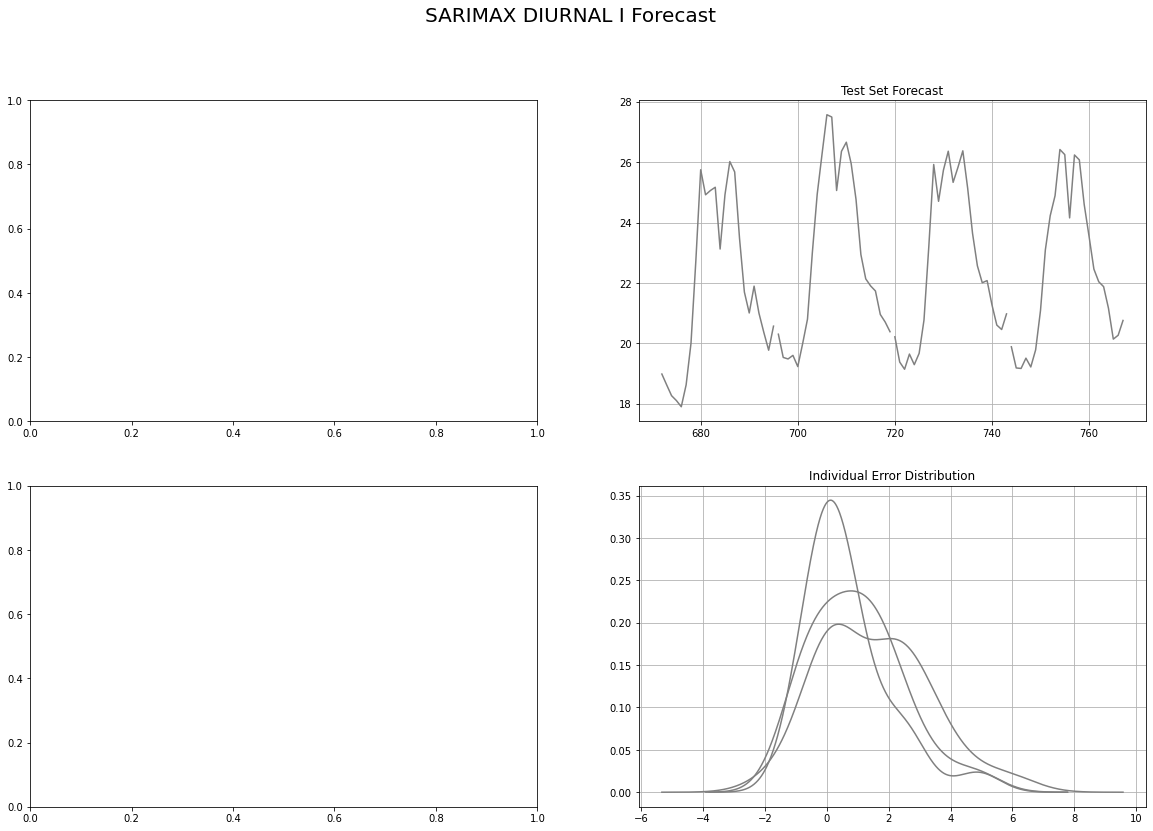

In [16]:
# plotting extended foecast and multiple cross validations
experiment = 'SARIMAX DIURNAL'
plot_df = forecast_datasets[experiment].keys()
plot_multi_model_evaluation(forecast_datasets, experiment=experiment)

In [8]:
def plot_multi_model_evaluation(forecast_dataset, experiment, save_dir=None, figsize=(20,13), save_fig=False):
    '''
    Plot model's predictions on training and test sets, along with key performance metrics.
    :param forecast_df: DataFrame consisting of predicted and ground truth consumption values
    :param model_name: model identifier
    :param metrics: key performance metrics
    :param figsize: size of matplotlib figure
    :param train_date: string representing date model was trained
    '''

    # assign df for specific experiment
    experiment_df = forecast_dataset[experiment]
    
    for dma in experiment_df.keys(): 
        # assign df for specific dma
        df_dma = experiment_df[dma].copy()
        
        no_folds = max([int(col[-3]) for col in df_dma.columns])+1
        no_test = max([int(col[-1]) for col in df_dma.columns])+1
        pointer = 0
        
        width_df = int((df_dma.shape[1]-10) / (no_folds * no_test))
        
        # initialise figure
        fig = plt.figure(figsize=figsize)
        fig.suptitle(experiment+' '+dma+' Forecast', fontsize=20)
        ax1 = fig.add_subplot(2, 2, 1)
        ax2 = fig.add_subplot(2, 2, 2)
        ax3 = fig.add_subplot(2, 2, 3)
        ax4 = fig.add_subplot(2, 2, 4)

        # iterate over each fold
        for test in range(no_test): 
            for fold in range(no_folds): 
                forecast_df = df_dma.rename(columns={col: col[:-9] for col in df_dma.columns}).copy().iloc[:, pointer: pointer+width_df]
                print(forecast_df)
                # Plot test performance
                forecast_df[pd.isnull(forecast_df["model"])][["forecast"]].plot(color=["grey"], y=None,
                                        title="Test Set Forecast", grid=True, ax=ax2, legend=False)
                #ax2.fill_between(x=forecast_df.index, y1=forecast_df['pred_int_low'], y2=forecast_df['pred_int_up'], color='b', alpha=0.2)
                #ax2.fill_between(x=forecast_df.index, y1=forecast_df['conf_int_low'], y2=forecast_df['conf_int_up'], color='b', alpha=0.3)
                #ax2.set(xlabel=None)

                # Plot residuals
                #forecast_df[["residuals", "error"]].plot(ax=ax3, color=["green", "red"], title="Residuals", grid=True)
                #ax3.set(xlabel=None)

                # Plot residuals distribution
                forecast_df[["error"]].plot(ax=ax4, color=["grey"], kind='kde', y=None,
                                        title="Individual Error Distribution", grid=True, legend=False)
                ax4.set(ylabel=None)

                if save_fig:
                    save_dir = cfg['PATHS']['FORECAST_VISUALIZATIONS'] if save_dir is None else save_dir
                    plt.savefig(save_dir + '/' + model_name + '_eval_' +
                                train_date + '.png')
                
                # update pointer
                pointer += width_df 

        # plot mean results
        forecast_df = df_dma.rename(columns={col: col[:-9] for col in df_dma.columns}).copy()

        # Plot test performance
        if "test_pred" in forecast_df.columns:
            forecast_df[pd.isnull(df_dma["model_fold_0_0"])][["mean_gt", "mean_forecast", "mean_test_pred"]].plot(color=["black", "red", "yellow"],
                                                                                title="Test Set Forecast", grid=True, ax=ax2)
        else:
            forecast_df[pd.isnull(df_dma["model_fold_0_0"])][["mean_gt", "mean_forecast"]].plot(color=["black", "red"],
                                                                                title="Test Set Forecast", grid=True, ax=ax2)
        ax2.fill_between(x=forecast_df.index, y1=forecast_df['mean_pred_int_low'], y2=forecast_df['mean_pred_int_up'], color='b', alpha=0.1)
        ax2.fill_between(x=forecast_df.index, y1=forecast_df['mean_conf_int_low'], y2=forecast_df['mean_conf_int_up'], color='b', alpha=0.2)
        ax2.set(xlabel=None)
        
        # plot train performance
        forecast_df[["mean_gt", "mean_model"]].plot(color=["black", "green"], title="Training Set Predictions",
                                                                                    grid=True, ax=ax1)
        ax1.set(xlabel=None)
        
        # plot residuals
        forecast_df[["mean_residuals", "mean_error"]].plot(ax=ax3, color=["green", "red"], title="Residuals", grid=True)
        ax3.set(xlabel=None)

        # Plot residuals distribution
        forecast_df[["mean_residuals", "mean_error"]].plot(ax=ax4, color=["green", "red"], kind='kde',
                                        title="Residuals Distribution", grid=True)
        ax4.set(ylabel=None)

        # legends
        """ ax2_labels = ['data', 'mean forecast', 'mean single-step prediction', 'mean prediction interval', 'mean confidence interval', 'individual test forcasts']
        leg = ax2.legend(ax2_labels, loc='right', bbox_to_anchor=(1.3, 0.5),
        fancybox=False, shadow=False, ncol=1, edgecolor='w', borderpad=0.5)
        leg.get_frame().set_linewidth(0.5)

        ax4_labels = ['mean residuals', 'mean errors', 'individual fold errors']
        leg = ax4.legend(ax4_labels, loc='right', bbox_to_anchor=(1.3, 0.5),
        fancybox=False, shadow=False, ncol=1, edgecolor='w', borderpad=0.5)
        leg.get_frame().set_linewidth(0.5) """
    return


def decomposition_metrics(forecast_df):
    '''
    Return metrics relating to mode performance for a single fold.
    :param forecast_df: DataFrame consisting of predicted and ground truth consumption values
    '''
    metrics = {}
    metrics['residuals_mean'] = forecast_df["residuals"].mean()
    metrics['residuals_std'] = forecast_df["residuals"].std()
    metrics['error_mean'] = forecast_df["error"].mean()
    metrics['error_std'] = forecast_df["error"].std()
    metrics['MAE'] = forecast_df["error"].apply(lambda x: np.abs(x)).mean()
    forecast_df["error_pct"] = forecast_df["error"] / forecast_df["gt"]
    metrics['MAPE'] = forecast_df["error_pct"].apply(lambda x: np.abs(x)).mean()
    metrics['MSE'] = forecast_df["error"].apply(lambda x: x ** 2).mean()
    metrics['RMSE'] = np.sqrt(metrics['MSE'])  # root mean squared error
    metrics['MAE_std'] = forecast_df["error"].apply(lambda x: np.abs(x)).std()
    metrics['MAPE_std'] = forecast_df["error_pct"].apply(lambda x: np.abs(x)).std()
    metrics['MSE_std'] = forecast_df["error"].apply(lambda x: x ** 2).std()
    metrics_df = pd.DataFrame.from_records([metrics])

    return metrics_df

In [463]:
a = pd.concat([forecast_df['model'], forecast_df['model']], axis=1)
a['model'].iloc[:, :1]

,model
0,36.722057
1,32.567748
2,29.306721
3,28.101506
4,29.636130
...,...
659,NaN
660,NaN
661,NaN
662,NaN
